In [31]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [0]:
%%cython
import numpy as np
import random
import matplotlib.pyplot as plt


cdef extern from "math.h":
    double exp(double)
    double sqrt(double)
    double log(double)

cdef class GP:
    cdef double beta
    cdef int ns
    cdef xt, yt
    cdef double[:,:] i_cov
    cdef double[:] param
    cdef dict param_cache

    cdef double covariance_func(self, double xi, double xj):
        cdef double theta0 = 1.0
        cdef double theta1 = 1.0
        cdef double theta2 = 0
        cdef double theta3 = 16.0
        return theta0 * exp(-0.5 * theta1 * (xi - xj) * (xi - xj)) + theta2 + theta3 * xi * xj


    def __init__( self ):
        self.beta = 10.0
        self.param_cache = {}

    def learn(self, xt, yt ):
        cdef int i,j
        self.xt = xt
        self.yt = yt
        self.ns = len(xt)

        cdef double[:,:] cov = np.zeros((self.ns, self.ns))

        for i in range(self.ns):
            for j in range(self.ns):
                cov[i,j] = self.covariance_func(xt[i], xt[j])
                if i==j:
                    cov[i,j] += 1/self.beta

        self.i_cov = np.linalg.inv(cov)
        self.param = np.dot(self.i_cov, self.yt)
        self.param_cache.clear()

    def plot(self, x):
        mus, sigmas = self.predict( x.reshape(-1,1) )
        plt.plot( x, mus )
        
        y_max = mus + np.sqrt(sigmas.flatten())
        y_min = mus - np.sqrt(sigmas.flatten())

        plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )
        plt.plot(self.xt, self.yt)
        plt.show()


    def predict( self, x ):
        mus = []
        sigmas = []
        n = len(x)
        tt = [y - np.random.normal() / self.beta for y in self.yt]
        for k in range(n):
            v = np.zeros((self.ns))
            for i in range(self.ns):
                v[i] = self.covariance_func(x[k], self.xt[i])
            c = self.covariance_func(x[k], x[k]) + 1.0 / self.beta
            
            mu = np.dot(v, np.dot(self.i_cov, tt))
            sigma = c - np.dot(v, np.dot(self.i_cov, v))
            
            mus.append(mu)
            sigmas.append(sigma)
        
        return np.array(mus), np.array(sigmas)


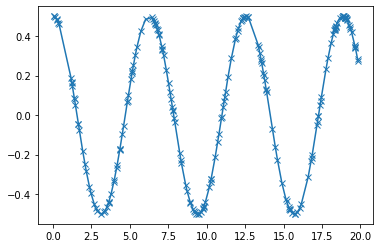

In [39]:
xt = np.sort(np.random.rand(200)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

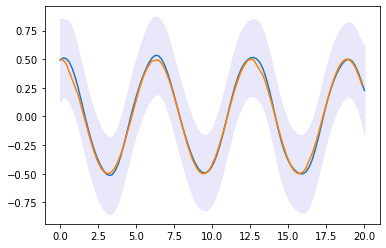

CPU times: user 402 ms, sys: 138 ms, total: 540 ms
Wall time: 404 ms


In [40]:
%%time
gp = GP()
gp.learn( xt.reshape((-1,1)), yt )
gp.plot(np.linspace( 0,20,100 ) )

In [41]:
%%time
gp.predict(np.linspace( 0,20,100 ).reshape(-1,1))

CPU times: user 37.6 ms, sys: 25.9 ms, total: 63.5 ms
Wall time: 37 ms


(array([ 0.53199602,  0.48550095,  0.41812719,  0.33813865,  0.25391515,
         0.17173415,  0.09435975,  0.02096835, -0.05156107, -0.12650962,
        -0.20520341, -0.28577917, -0.36330453, -0.43113682, -0.48287667,
        -0.51405628, -0.52289253, -0.50992993, -0.47694329, -0.42578896,
        -0.35783527, -0.27421648, -0.17666454, -0.06835114,  0.0458099 ,
         0.15961917,  0.26658593,  0.36094953,  0.43824607,  0.49525649,
         0.52957896,  0.53930541,  0.52319658,  0.48138409,  0.41620478,
         0.33256249,  0.23737176,  0.13810651,  0.04100164, -0.05027161,
        -0.134797  , -0.21335022, -0.28660038, -0.35349087, -0.41064246,
        -0.45311048, -0.47614302, -0.47708455, -0.45650239, -0.41799987,
        -0.36680921, -0.30781072, -0.24385351, -0.17508326, -0.09953233,
        -0.01471549,  0.08039451,  0.18375072,  0.28957116,  0.38890717,
         0.47132307,  0.52721913,  0.55011584,  0.53820444,  0.49467455,
         0.42670543,  0.34343956,  0.25359635,  0.1